In [34]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy
import seaborn as sns
sns.set_theme()

from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.penalty.CompareVolatility import CompareVolatility, VolatilityComparisonConfig
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.config import DEVICE

In [22]:
import ray
ray.init()

2022-12-11 17:41:33,180	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.0
Ray version:,2.0.1


# Evaluation - Black Scholes

In [37]:
trading_freq: int = 5
uncertainty_aversion: float = 130
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)
hedge_objective = MeanVariance(uncertainty_aversion)

In [36]:
estimated_generator = BlackScholesGenerator(
    drift=np.array([0.0]),
    sigma=np.array([0.2]),
).provide_generator(
    initial_value=np.array([1.0]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
reference_paths = estimated_generator(2**16)

pen_config = VolatilityComparisonConfig(td)
penalizer = CompareVolatility(reference_paths, pen_config, transform=lambda x: x ** 2)

## Test Data

In [4]:
pars_f = 'resources/uncertainty-test-sets/bs/sigmas_2_1_100000.npy'
pars_coarseness = int(pars_f.split('_')[1])
pars = np.load(pars_f, allow_pickle=True)

In [94]:
sigma_by_coarseness = {c: np.load(f'resources/uncertainty-test-sets/bs/sigmas_{c}_1_100000.npy', allow_pickle=True) for c in (1, 2, 3,)}

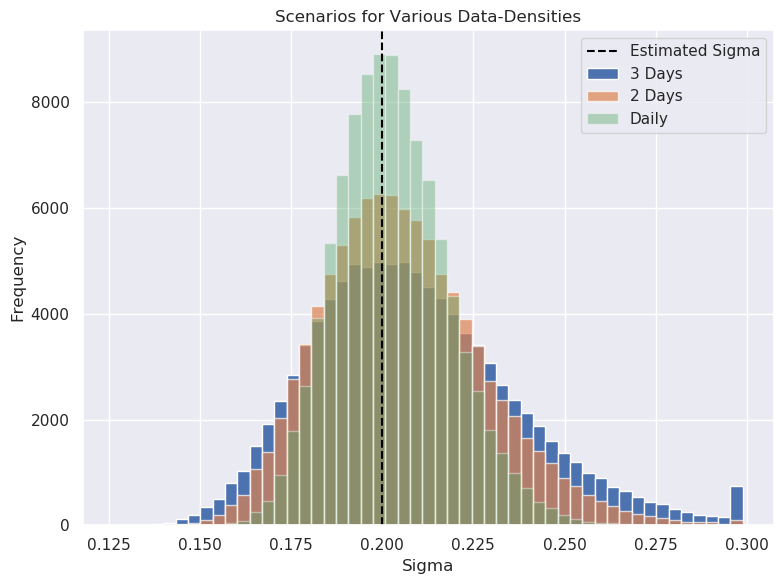

In [124]:
fig, ax = plt.subplots(figsize=(8, 6))
_, bins = np.histogram([v for l in sigma_by_coarseness.values() for v in l], bins=51)
ax.hist(sigma_by_coarseness[3], bins=bins, alpha=1., label='3 Days')
ax.hist(sigma_by_coarseness[2], bins=bins, alpha=.7, label='2 Days')
ax.hist(sigma_by_coarseness[1], bins=bins, alpha=.4, label='Daily')
ax.axvline(0.2, c='black', ls='--', label='Estimated Sigma')
ax.set_xlabel('Sigma')
ax.set_ylabel('Frequency')
ax.set_title('Scenarios for Various Data-Densities')
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
# plt.savefig('figs/BlackScholesUncertaintyData.pdf')
plt.show()

### Test Generators

In [5]:
test_generators = [
    BlackScholesGenerator(
        drift=np.zeros(1),
        sigma=np.ones(1)*par,
    ).provide_generator(
        initial_value=np.array([1.0]),
        times=td.times,
        random_number_generator=np.random.default_rng(1111 + i),
        device='cpu',
    ) for i, par in enumerate(pars)
]

In [23]:
@ray.remote
def generate(index, gen, number_of_paths):
    return index, gen(number_of_paths)

## Loading Deep Hedges and Robust Hedge GANs

In [14]:
target_folder = f'resources/network-states/test_bs_new/ua{uncertainty_aversion:03}/tf_{trading_freq:02}'
target_folder

'resources/network-states/test_bs_new/ua130/tf_05'

### Deep and Optimal Hedges

In [13]:
deep_hedge = DeepHedge(
    DeepHedgeConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([1.0], dtype=torch.float32, device=DEVICE),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=1,
            dim_of_tradable_asset=1,
            number_of_layers=2,
            nodes_in_intermediate_layers=128,
        ),
    )
)
optimal_hedge = deepcopy(deep_hedge)

In [16]:
deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge_post_trained.pt'))

<All keys matched successfully>

In [17]:
optimal_hedge.load_state_dict(torch.load(f'{target_folder}/optimal_hedge_pc{pars_coarseness}.pt'))

<All keys matched successfully>

### Robust Hedge GANs

In [76]:
penalty_scales = [10, 25, 50, 75, 100, 125, 150]

In [25]:
rh_gans = {pen_s: deepcopy(deep_hedge) for pen_s in penalty_scales}

In [42]:
for pen_s in penalty_scales:
    rh_gans[pen_s].load_state_dict(torch.load(f'{target_folder}/v_cv_{pen_s:03.0f}/rhgan_dh.pt'))

## Evaluating OOSP

In [84]:
no_to_display = 10000

In [85]:
dh_oosp_by_par = {}
oh_oosp_by_par = {}
rhgan_oosp_by_pen_by_par = {pen: {} for pen in penalty_scales}
distances_to_estimate_dict = {}
for indices in tqdm(np.array_split(np.arange(no_to_display), np.arange(48,no_to_display,48))):
    for i, paths in ray.get([generate.remote(index=i, gen=test_generators[i], number_of_paths=no_to_display) for i in indices]):
        paths = paths.cuda()
        increments = torch.diff(paths, 1, 1)
        dh_oosp_by_par[i] = hedge_objective(deep_hedge(increments)).cpu().item()
        oh_oosp_by_par[i] = hedge_objective(optimal_hedge(increments)).cpu().item()
        for pen in penalty_scales:
            rhgan_oosp_by_pen_by_par[pen][i] = hedge_objective(rh_gans[pen](increments)).cpu().item() 
        distances_to_estimate_dict[i] = penalizer(paths[:, :, 0:2]).item()

In [86]:
dh_oosps = [dh_oosp_by_par[i] for i in range(no_to_display)]
oh_oosps = [oh_oosp_by_par[i] for i in range(no_to_display)]
rhgan_oosps_by_pen = {pen: [rhgan_oosp_by_pen_by_par[pen][i] for i in range(no_to_display)] for pen in penalty_scales}
distances_to_estimate = [distances_to_estimate_dict[i] for i in range(no_to_display)]

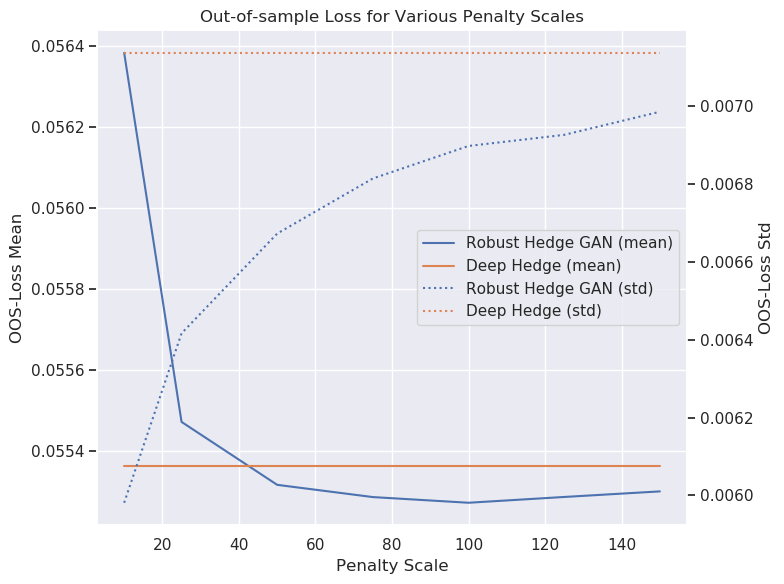

In [93]:
fig, axl = plt.subplots(figsize=(8,6))
axl.plot(penalty_scales, [np.mean(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], label='Robust Hedge GAN (mean)')
axl.plot(penalty_scales, [np.mean(dh_oosps) for pen in penalty_scales], c='C1', label='Deep Hedge (mean)')
axl.set_title('Out-of-sample Loss for Various Penalty Scales')
axl.set_xlabel('Penalty Scale')
axl.set_ylabel('OOS-Loss Mean')

axr = axl.twinx()
axr.plot(penalty_scales, [np.std(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], ls=':', label='Robust Hedge GAN (std)')
axr.plot(penalty_scales, [np.std(dh_oosps) for pen in penalty_scales], c='C1', ls=':', label='Deep Hedge (std)')
axr.set_ylabel('OOS-Loss Std')
axr.grid(False)

lines, labels = axl.get_legend_handles_labels()
lines2, labels2 = axr.get_legend_handles_labels()
axr.legend(lines + lines2, labels + labels2, loc=5)
plt.tight_layout()
# plt.savefig('figs/BlackScholesOOSPComparison.pdf')
plt.show()